# Tessa Vu

### MUSA 6950

### Dr. Li

# PART 1: FILTER AND PLOT SPATIAL DISTRIBUTION

Read the tutorial of [lab 2](https://github.com/xiaojianggis/ai-urban-sustainability/blob/main/lab2-vector-data-manipulation/1.%20geopandas-spatial-analysis.ipynb) to an external site. Plot the spatial distribution of the traffic accidents for any certain day, month, or year at the census tract level. Just show me you can use and and or to do multiple queries.

***Hint**: Use `&` and `|` to create multiple queries. Then use the spatial join to get the number of accidents at the census tract level.*

In [2]:
# Import relevant modules.
import geopandas as gpd
import pandas as pd
import time
from matplotlib import pyplot as plt
import pyproj
from itertools import repeat
import sys
import time
import fiona
from pyproj import Transformer
from shapely.geometry import mapping, shape
import rtree
import os, os.path
from statistics import median
from shapely.ops import transform
from functools import partial

In [3]:
# Read shapefile into data frame with geometric information.
accident = gpd.read_file("data/crash_data_collision_crash_2007_2017/crash_data_collision_crash_2007_2017.shp")

In [4]:
# Read Philly tract shapefile into geodataframe.
censusMap = gpd.read_file("data/census_tract_data/census-tract-data.shp")

In [5]:
# Reproject the crash data.
accident_reprojected = accident.to_crs("EPSG:4269")

In [6]:
# Filter traffic accidents by December, 2017.
accident_12_2017 = accident_reprojected.loc[(accident_reprojected["crash_mont"] == 12) & (accident_reprojected["crash_year"] == 2017)]

In [7]:
# Do a spatial join and store in a variable.
joined = gpd.sjoin(accident_12_2017, censusMap, how = "left", predicate = "intersects")

In [8]:
# Group tracts.
results = joined.groupby("tract").size().to_frame("size")

In [9]:
# Merge accident data to the shapefile.
trafficAccident = pd.merge(censusMap, results, on = "tract")

<Axes: >

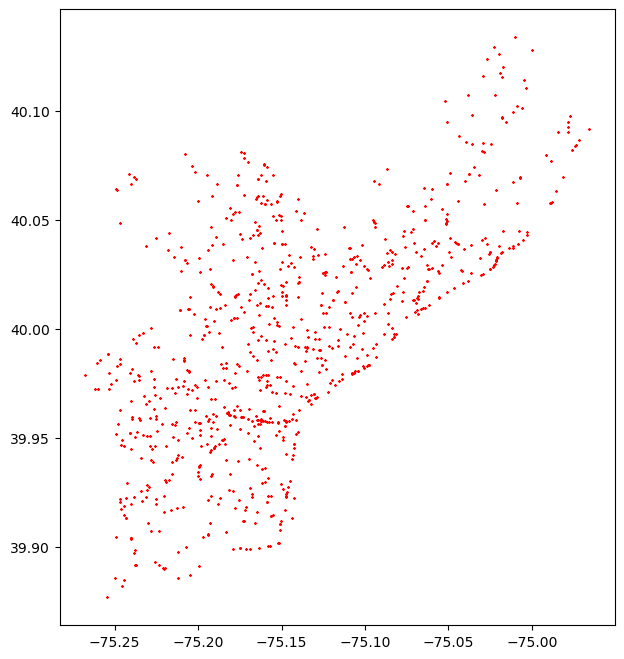

<Figure size 800x800 with 0 Axes>

In [10]:
# Plot points on a chart.
fig, ax = plt.subplots(1, figsize = (8, 8))

plt.figure(figsize = (8, 8))
accident_12_2017.plot(marker = "*", 
                   ax = ax, 
                   color = "red", 
                   markersize = 1)

In [11]:
# Group the data by census tracts.
results_2017 = joined.groupby("tract").size().to_frame("size")

In [12]:
# Merge 2017 accident data to shapefile.
traffic_accidents_2017 = pd.merge(censusMap, results_2017, on = "tract")

<Axes: >

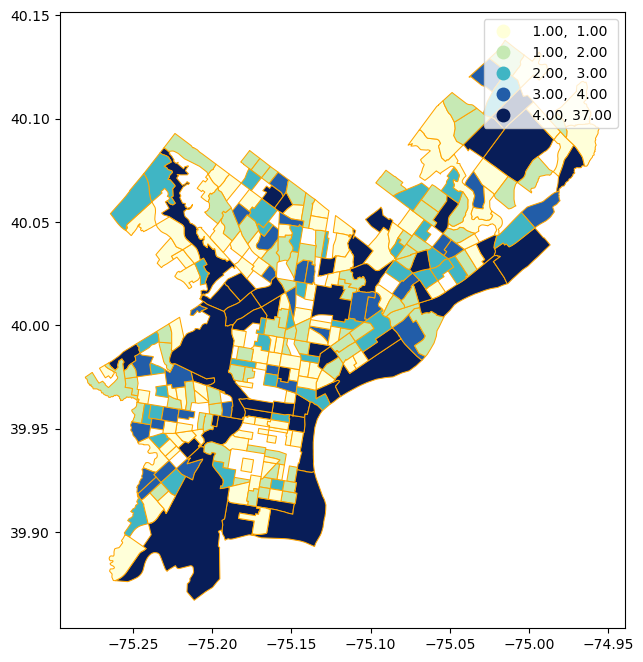

In [13]:
# Create chloropleth map.
fig, ax = plt.subplots(1, figsize = (8, 8))

# Declare the target column, color map, line width, number of classes, and data sorting scheme.
traffic_accidents_2017.plot(column = "size", 
                         cmap = "YlGnBu", 
                         edgecolor = "orange",
                         ax = ax,
                         linewidth = 0.75,
                         legend = True,
                         k = 5,
                         scheme = "quantiles")

# PART 2: USING R-TREE FOR SPATIAL OVERLAY

Check the [tutorial here](https://github.com/xiaojianggis/ai-urban-sustainability/blob/main/lab2-vector-data-manipulation/3.%20advanced_analysis_fiona_shapely.ipynb) to an external site. Please use R-Tree + Shapely + Fiona to conduct the overlay of two shapefiles. You can use any shapefiles you find. You can use ArcGIS/QGIS to do the project conversion and make the two shapefiles have the same projection. Then conduct the overlay and calculate the statistics of point features inside your polygon features. The statisitcs can be count, mean value, median value, etc.

In [14]:
# Store well points.
ut_groundwater_wells_points = "data/ut_groundwater_wells/Well_Logs.shp"

In [15]:
# Read Salt Lake County polygon shapefiles.
sl_tracts_2020 = "data/sl_tracts_2020/sl_tracts_2020.shp"
sl_tracts_2020_output = "data/sl_tracts_2020_output/sl_tracts_2020_output.shp"

# Open and store well points.
utah = fiona.open(ut_groundwater_wells_points, "r")

# Create empty spatial index object.
index = rtree.index.Index()

In [16]:
# Populate spatial index.
i = 0
for fid, feature in utah.items():
    i += 1
    # When iterating through features, if the remainder is 0, print.
    if i % 10000 == 0: print(i)
    geometry = shape(feature["geometry"])
    
    # Add a buffer in to create R-Tree.
    geometry_buffer = geometry.buffer(10) 
    geotype = feature["geometry"]["type"]
    
    index.insert(fid, geometry_buffer.bounds)

10000
20000
30000
40000
50000
60000
70000
80000
90000


In [17]:
# loop all polygons and assign values.
with fiona.open(sl_tracts_2020, "r") as polygon_ut:
    schema = polygon_ut.schema.copy()
    # Create new column in properties called well_num to store the number of wells and make it an integer type.
    schema["properties"]["well_num"] = "int"
    input_crs = polygon_ut.crs
    
    # Write intersected point into new shapefile.
    with fiona.open(sl_tracts_2020_output, "w", "ESRI Shapefile", schema, input_crs) as output:
        
        # Loop through polygon feature and number them.
        for idx, feature_polygon in enumerate(polygon_ut):
            # If the polygon remainder is 0, print the polygon number.
            if idx % 10 == 0:
                print("Polygon:", idx)

            # Store geometry data into variable.
            geometry_polygon = shape(feature_polygon["geometry"])
            # Store property data into variable.
            attribute_polygon = feature_polygon["properties"]
            
            # Use bounding box to find close, but not intersecting, point features.
            fids = [int(i) for i in index.intersection(geometry_polygon.bounds)]
            print("Narrowed to", len(fids))
            
            # Count number of groundwater wells.
            count = 0
            
            # Loop all features in bounding box and judge if they're intersected.
            for fid in fids:
                feature_point = utah[fid]
                geometry_point = shape(feature_point["geometry"])
                
                # If point is intersected with polygon, save point feature into output shapefile.
                if geometry_polygon.intersects(geometry_point):
                    count = count + 1

            # Count the number of wells and write in new well_num property.
            attribute_polygon["well_num"] = count
            output.write({"geometry": mapping(geometry_polygon),"properties": attribute_polygon})

Polygon: 0
Narrowed to 86
Narrowed to 228
Narrowed to 13
Narrowed to 131


C:\Users\Tess\AppData\Local\Temp\ipykernel_17628\2854155784.py:39: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  attribute_polygon["well_num"] = count


Narrowed to 36
Narrowed to 6
Narrowed to 4
Narrowed to 33
Narrowed to 23
Narrowed to 46
Polygon: 10
Narrowed to 61
Narrowed to 196
Narrowed to 12
Narrowed to 32
Narrowed to 12
Narrowed to 5
Narrowed to 97
Narrowed to 17
Narrowed to 24
Narrowed to 27
Polygon: 20
Narrowed to 2
Narrowed to 2
Narrowed to 23
Narrowed to 32
Narrowed to 4
Narrowed to 31
Narrowed to 0
Narrowed to 4
Narrowed to 6
Narrowed to 56
Polygon: 30
Narrowed to 70
Narrowed to 3
Narrowed to 21
Narrowed to 269
Narrowed to 11
Narrowed to 7
Narrowed to 16
Narrowed to 30
Narrowed to 2
Narrowed to 11
Polygon: 40
Narrowed to 167
Narrowed to 4
Narrowed to 35
Narrowed to 21
Narrowed to 97
Narrowed to 13
Narrowed to 13
Narrowed to 122
Narrowed to 24
Narrowed to 24
Polygon: 50
Narrowed to 13
Narrowed to 6
Narrowed to 41
Narrowed to 6
Narrowed to 22
Narrowed to 115
Narrowed to 0
Narrowed to 24
Narrowed to 26
Narrowed to 3
Polygon: 60
Narrowed to 4
Narrowed to 207
Narrowed to 107
Narrowed to 4
Narrowed to 27
Narrowed to 29
Narrowed t

In [18]:
count

9

In [19]:
len(fids)

27

Text(0.5, 1.0, 'NUMBER OF GROUNDWATER WELLS\nSalt Lake County, UT')

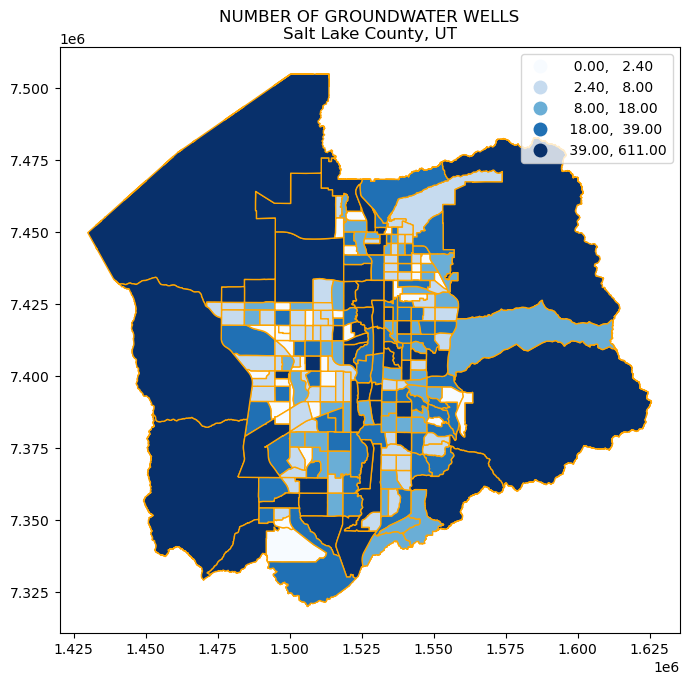

In [20]:
# Create groundwater well geodataframe.
sl_groundwater_wells = gpd.read_file(sl_tracts_2020_output)

# Create chloropleth map.
fig, ax = plt.subplots(1, figsize = (8, 8))

# Declare the target column, color map, line width, number of classes, and data sorting scheme.
sl_groundwater_wells.plot(column = "well_num",
                          cmap = "Blues",
                          edgecolor = "orange",
                          ax = ax,
                          linewidth = 1,
                          legend = True,
                          k = 5,
                          scheme = "quantiles")

# Place title.
ax.set_title("NUMBER OF GROUNDWATER WELLS\nSalt Lake County, UT")